# Andreas Dörnbrack Collaboration
Aus dem DLR Elib haben wir eine JSON Datei runtergeladen, in dem sich ein Dictionary für jeden Eintrag befindet, also für jede Publikation. Die Idee ist aus dieder Datei die Liste der Autoren rauszusuchen und zu bestimmen, wie häufig die Autor:innen zusammen gearbeitet haben. Am Ende soll ein Netzwerkplot erstellt werden, in dem jeder Knoten ein Name ist und die Verbindung zu anderen Autor:innen stellt die Stärke dar, wie häufig die Autor:innen zusammen gearbeitet haben.  

In [1]:
import json
from itertools import combinations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import distinctipy
import fa2
import random

In [2]:
def correct_name(creator):
    name = creator.get('name', {}).get('family').strip() # Remove leading/trailing whitespace
    if "Kaifler" in name:
        given_name = creator.get('name', {}).get('given')
        if given_name == "Natalie":
            name = "N. " + name
        elif given_name == "Bernd":
            name = "B. " + name
    return name_corrections.get(name, name)  # fallback to original if not found

name_corrections = {
    "Behrend": "Behrendt",
    "Bugliaro Goggia": "Bugliaro",
    "Chouza-Keil": "Chouza",
    "Garhammar": "Garhammer",
    "Grooss": "Grooß",
    "Kröger, C. (Dep. of Atmospheric Science, Univ. of Wyoming, Laramie, WY, USA": "Krüger",
    "LeClercq": "Le Clercq",
    "Mayr, G. Mayr, G.": "Mayr",
    "Meleshko V.V.": "Meleshko",
    "Oltmans": "Oltmanns",
    "Pommerau, J.P. (Service d'Aeronomie, Verrieres-le-Buisson, F": "Pommerau",
    "Schumann U.": "Schumann",
    "Ulanovski": "Ulanovsky",
    "Weiß-Rehm": "Weiß",
    "Wilms-Grabe": "Wilms",
    "plus": None
}

# Step 2: Preprocess alias keys to match cleaned input
raw_aliases = {
    "lmu": "LMU, München, Deutschland",
    "lmu, münchen": "LMU, München, Deutschland",
    "Lmu München, München": "LMU, München, Deutschland",
    "Inst. f. Stratosphärische Chemie, FZ Jülich": "FZJ, Jülich, Deutschland",
    "FZJ, Germany": "FZJ, Jülich, Deutschland",
    "Iek-7, Forschungszentrum Jülich": "FZJ, Jülich, Deutschland",
    "Fz Jülich, Jülich": "FZJ, Jülich, Deutschland",
    "Research Centre Jülich Gmbh, Jülich": "FZJ, Jülich, Deutschland",
    "Fz Jülich": "FZJ, Jülich, Deutschland",
    "Forschungszentrum Jülich": "FZJ, Jülich, Deutschland",
    "Research Centre Jülich": "FZJ, Jülich, Deutschland",
    "dlr, IPA": "DLR, Oberpfaffenhofen, Deutschland",
    "Dlr-Ipa": "DLR, Oberpfaffenhofen, Deutschland",
    "Dlr": "DLR, Oberpfaffenhofen, Deutschland",
    "Dlr, Ipa / Lmu": "DLR, Oberpfaffenhofen, Deutschland",
    "Dlr, Fx": "DLR, Oberpfaffenhofen, Deutschland",
    "Lmu München, Dlr-Ipa": "DLR, Oberpfaffenhofen, Deutschland",
    "Dlr, Ly": "DLR, Hamburg, Deutschland",
    "Kit, Karlsruhe, Germany": "KIT, Karlsruhe, Deutschland",
    "Kit,  Karlsruhe, Germany": "KIT, Karlsruhe, Deutschland",
    "Kit, Karlsruhe": "KIT, Karlsruhe, Deutschland",
    "Imk, Karlsruhe": "KIT, Karlsruhe, Deutschland",
    "Kit, Imk, KArlsruhe": "KIT, Karlsruhe, Deutschland",
    "Imk-Tro, Karlsruhe": "KIT, Karlsruhe, Deutschland",
    "Inst. For Meteorology and Climate, Karlsruhe,": "KIT, Karlsruhe, Deutschland",
    "Inst. Für Meteorologie Und Klimaforschung, Fz Karlsruhe": "KIT, Karlsruhe, Deutschland",
    "Univ. Bayreuth, Germany": "Universität Bayreuth, Deutschland",
    "Univ. Bremen, Bremen": "Universität Bremen, Deutschland",
    "Awi, Bremerhaven": "AWI, Bremerhaven, Deutschland",
    "Awi Für Polar Und Meeresforschung, Bremerhaven": "AWI, Bremerhaven, Deutschland",
    "Alfred-Wegener-Institut Für Polar Und Meeresforschung, Bremerhaven": "AWI, Bremerhaven, Deutschland",
    "Leibniz-Institute Of Atmospheric Physics, Kühlungsborn, Germany": "IAP, Kühlungsborn, Deutschland",
    "Leibniz Institute Of Atmospheric Physics, Kühlungsborn, Germany": "IAP, Kühlungsborn, Deutschland",
    "Leibniz-Institute Of Atmospheric Physics, Kühlungsborn": "IAP, Kühlungsborn, Deutschland",
    "Iap Kühlungsborn": "IAP, Kühlungsborn, Deutschland",
    "Univ. Rostock, Kühlungsborn": "Universität Rostock, Deutschland",
    "Univ. Rostock, Ostseebad Kühlungsborn": "Universität Rostock, Deutschland",
    "Uni Mainz": "JGU, Mainz, Deutschland",
    "Univ. Mainz": "JGU, Mainz, Deutschland",
    "Univ. Mainz, Mainz": "JGU, Mainz, Deutschland",
    "Inst. Für Physik Der Atmosphäre, Univ. Mainz": "JGU, Mainz, Deutschland",
    "Inst. F. Physik Der Atmosphäre, Universität Mainz": "JGU, Mainz, Deutschland",
    "Institute For Atmospheric Physics, Johannes Gutenberg University Mainz": "JGU, Mainz, Deutschland",
    "Universität Mainz": "JGU, Mainz, Deutschland", 
    "Johannes-Gutenberg-Univ., Mainz": "JGU, Mainz, Deutschland",
    "Johannes Gutenberg-Univ. Mainz, Mainz": "JGU, Mainz, Deutschland",
    "Inst. F. Atmospheric Physics, Johannes Gutenberg Univ., Mainz": "JGU, Mainz, Deutschland",
    "Johannes Gutenberg Univ. Mainz": "JGU, Mainz, Deutschland",
    "Johannes-Gutenberg Univ. Mainz": "JGU, Mainz, Deutschland", 
    "Mpi Mainz, Mainz": "MPI, Mainz, Deutschland",
    "Mpi F. Chemie, Mainz": "MPI, Mainz, Deutschland",
    "Max Planck Insitut Für Chemie, Mainz": "MPI, Mainz, Deutschland",
    "Mpi Für Chemie, Mainz": "MPI, Mainz, Deutschland",
    "Mpi-C": "MPI, Mainz, Deutschland",
    "Mpic Mainz": "MPI, Mainz, Deutschland",
    "Mpi Chemie, Mainz": "MPI, Mainz, Deutschland",
    "Max-Planck-Institute Of Chemistry, Mainz Germany": "MPI, Mainz, Deutschland",
    "Multiphase Chemistry Department, Max PLanck Institute For Chemistry, 55128 Mainz, Germany": "MPI, Mainz, Deutschland",
    "Biogeochemistry Department, Max PLanck Institute For Chemistry, 55128 Mainz, Germany": "MPI, Mainz, Deutschland",
    "Univ. Zu Köln": "Universität zu Köln, Deutschland",
    "Inst. F. Geophysik U. Meteorologie, Univ. Zu Köln": "Universität zu Köln, Deutschland",
    "Uni Leipzig": "Universität Leipzig, Deutschland",
    "Univ. Leipzig": "Universität Leipzig, Deutschland",
    "univ. leipzig, leipzig": "Universität Leipzig, Deutschland",
    "Lim, Leipzig": "Universität Leipzig, Deutschland",
    "Ift, Leipzig": "IfT, Leipzig, Deutschland",
    "Leibniz Institute For Tropospheric Research, Leipzig": "IfT, Leipzig, Deutschland",
    "tropos, Leipzig": "IfT, Leipzig, Deutschland",
    "Freie Universität, Berlin": "FU Berlin, Deutschland",
    "Institut Für Meteorologie, Berlin": "FU Berlin, Deutschland",
    "Inst. F. Experimentalphysik, Fu Berlin": "FU Berlin, Deutschland",
    "Inst. F. Meteorologie, Fu Berlin": "FU Berlin, Deutschland",
    "Mpi-K/Dlr": "MPI, Heidelberg, Deutschland",
    "Mpik, Heidelberg": "MPI, Heidelberg, Deutschland",
    "Mpi F. Kernphysik, Heidelberg": "MPI, Heidelberg, Deutschland",
    "Mpi Für Kernphysik, Heidelberg": "MPI, Heidelberg, Deutschland",
    "Universität Heidelberg, Inst. F. Umweltphys., Heidelberg": "Universität Heidelberg, Deutschland",
    "Univ. Heidelberg, Heidelberg": "Universität Heidelberg, Deutschland",
    "Uni Heidelberg": "Universität Heidelberg, Deutschland",
    "Iup, Univ. Heidelberg": "Universität Heidelberg, Deutschland",
    "Mpi-M, Hamburg": "MPI, Hamburg, Deutschland",
    "Mpi, Hamburg, Germany": "MPI, Hamburg, Deutschland",
    "Mpi F. Meteorologie, Hamburg": "MPI, Hamburg, Deutschland",
    "Univ. Hamburg": "Universität Hamburg, Deutschland",
    "Gkss Forschungszentrum Geesthacht": "HZG, Geesthacht, Deutschland",
    "Rolls-Royce Deutschland, Dahlewitz, Germany": "Rolls-Royce, Dahlewitz, Deutschland",
    "Dlr, Ft": "DLR, Braunschweig, Deutschland",
    "Inst. For Atmsopheric, Univ. Frankfurt": "Goethe-Universität Frankfurt, Deutschland",
    "J. W. Goethe Univ. Frankfurt, Frankfurt": "Goethe-Universität Frankfurt, Deutschland",
    "Uni Frankfurt": "Goethe-Universität Frankfurt, Deutschland",
    "Univ. Frankfurt": "Goethe-Universität Frankfurt, Deutschland",
    "Universität Frankfurt, Frankfurt, Germany": "Goethe-Universität Frankfurt, Deutschland",
    "Dwd": "DWD, Offenbach am Main, Deutschland",
    "Awi Potsdam": "AWI, Potsdam, Deutschland",
    "Dlr, Vt": "DLR, Stuttgart, Deutschland",
    "Technische Univ. Darmstadt": "TU Darmstadt, Deutschland",
    "Fachbereich Für Materialwissenschaften, Tu Darmstadt": "TU Darmstadt, Deutschland",
    "Physikalisches Institut Der Univ. Bonn": "Universität Bonn, Deutschland",
    "Univ. Of Bonn": "Universität Bonn, Deutschland",
    "Physikalisches Inst., Univ. Of Bonn, Bonn": "Universität Bonn, Deutschland",
    "Univ. Of Wuppertal, Wuppertal": "Universität Wuppertal, Deutschland",
    "Inst. F. Physik, Univ. Wuppertal": "Universität Wuppertal, Deutschland",
    "Univ. Hohenheim": "Universität Hohenheim, Deutschland",
    "Phys.-Techn. Bundesanstald, Braunschweig": "PTB, Braunschweig, Deutschland",
    "Eth, Zürich, Schweiz": "ETH, Zürich, Schweiz",
    "Eth Zürich, Zürich, Ch": "ETH, Zürich, Schweiz",
    "Eth, Zurich, Ch": "ETH, Zürich, Schweiz",
    "Atmospheric And Climate Services, Eth Zürich, Ch": "ETH, Zürich, Schweiz",
    "Eth Zürich": "ETH, Zürich, Schweiz",
    "Ethz\N{EM DASH}Swiss Federal Inst. Of Technology, Zurich, Ch": "ETH, Zürich, Schweiz",
    "Univ. Of Bern, Ch": "Universität Bern, Schweiz",
    "Observatoire De Neuchâtel, F": "Observatoire cantonal de Neuchâtel, Schweiz",
    "Inst. F. Meteorologie U. Geophysik, Univ. Innsbruck, A": "Universität Innsbruck, Österreich",
    "Univ. Innsbruck, Innsbruck, A": "Universität Innsbruck, Österreich",
    "Univ. Innsbruck, A": "Universität Innsbruck, Österreich",
    "Univ. Of Innsbruck, Innsbruck, A": "Universität Innsbruck, Österreich",
    "CONICET, Buenos Aires, Argentina": "CONICET, Buenos Aires, Argentinien",
    "Univ. Austral And Conicet, Pilar, Argentinien": "CONICET, Buenos Aires, Argentinien",
    "Consejo Nacional De Investigaciones Científicas Y Técnicas, Buenos Aires, Argentina": "CONICET, Buenos Aires, Argentinien",
    "Univ. Nacional De La PLata And Conicet, Argentinien": "CONICET, Buenos Aires, Argentinien", 
    "Universidad Austral, Lidtua (Cic), Argentina": "Universidad Austral, Buenos Aires, Argentinien",
    "Universidad De Buenos Aires, Buenos Aires, Argentina": "Universität Buenos Aires, Argentinien",
    "Servicio Meteorológico Nacional, Buenos Aires, Argentina": "SMN, Buenos Aires, Argentinien",
    "Dirección Meteorológica De Chile, Santiago De Chile, Chile": "DMC, Santiago de Chile, Chile",
    "University Leicester, United Kingdom": "Universität Leicester, Großbritannien", 
    "Metoffice, Exeter, Uk": "MetOffice, Exeter, Großbritannien",
    "Met Office, Exeter, Uk": "MetOffice, Exeter, Großbritannien",
    "Univ. Of Leeds, School Of Chemistry, Leeds, Uk": "Universität Leeds, Großbritannien",
    "School Of Environment, Univ. Of Leeds, Uk": "Universität Leeds, Großbritannien",
    "British Antarctic Survey, Cambridge, Uk": "BAS, Cambridge, Großbritannien",
    "Ecmwf, Reading, Uk": "ECMWF, Reading, Großbritannien",
    "Ecmwf, Uk": "ECMWF, Reading, Großbritannien",
    "Univ. Of Reading, Uk": "Universität Reading, Großbritannien",
    "Univ. Reading, Uk": "Universität Reading, Großbritannien",
    "Univ. Of Reading, Reading, Uk": "Universität Reading, Großbritannien",
    "Rolls-Royce Plc., Derby, Uk": "Rolls-Royce, Derby, Großbritannien",
    "Lancaster Univ., Lancaster, Uk": "Lancaster Universität, Großbritannien",
    "University Of Bath, Bath, Uk": "Universität Bath, Großbritannien", 
    "Ncas, University Of Manchester, Uk": "Universität Manchester, Großbritannien",
    "Department Of Meteorology, Stockholm University, Stockholm, Sweden 3": "SU, Stockholm, Schweden",
    "Misu, Univ. Stockholm, Schweden": "SU, Stockholm, Schweden",
    "Dept. Meteorology, Stockholm Univ.": "SU, Stockholm, Schweden",
    "Univ. Of Stockholm, S": "SU, Stockholm, Schweden",
    "Dep. Of Atmospheric Sciences, Texas A&M Univ., College Station, Tx, Usa": "TAMU, College Station, USA",
    "Univ. Of Virginia, Charlottesville, Va, Usa": "Universität Virginia, Charlottesville, USA",
    "Univ. Of Wyoming, Usa": "Universität Wyoming, Laramie, USA",
    "Univ. Of Wyoming, Laramie, Wy, Usa": "Universität Wyoming, Laramie, USA",
    "Clemson University, Clemson, Sc, Usa": "Universität Clemson, USA",
    "Nasa, Gsfc, Greenbelt, Maryland, Usa": "GSFC, Greenbelt, USA",
    "Nasa Goddard Space Flight Center, Greenbelt, Maryland, Usa": "GSFC, Greenbelt, USA",
    "Atmospheric Chemistry And Dynamics Branch, Nasa Goddard Space Flight Center, Greenbelt, Md, Usa": "GSFC, Greenbelt, USA",
    "Csar, Aeronautical University, Daytona Beach, Fl, Usa": "CSAR, Daytona Beach, USA",
    "Rosenstiel School Of Marine And Atmospheric Science, University Of Miami": "Universität Miami, USA",
    "Science Sytems and Appl.  Hampton, Virginia, Usa": "SSAI, Hampton, USA",
    "Science Systems And Applications, Inc, Hampton, Va, Usa": "SSAI, Hampton, USA",
    "Science Systems And Appl., Lanham, Maryland, Usa": "SSAI, Lanham, USA",
    "Nasa Langley, Hampton, Va, Usa": "LaRC, Hampton, USA",
    "Nasa Langley Research Center, Hampton, Va, Usa": "LaRC, Hampton, USA",
    "Brookhaven National Laboratory, NY, USA": "Brookhaven National Lab, NY, USA",
    "Saic, Lidar Application Group, Nasa Langley Research Center, Hampton, Virginia, Usa": "LaRC, Hampton, USA",
    "University Of Washington, Wa": "Universität Washington, USA",
    "Lab. For Atmosphericand Space Physics, Univ. Of Colorado, Boulder, Co, Usa": "Universität Colorado, Boulder, USA",
    "North West Res. Ass., Boulder, Co, Usa": "NWRA, Boulder, USA",
    "Northwest Research Associates, Boulder, Co, Usa": "NWRA, Boulder, USA",
    "Ncar, Boulder, Co, Usa": "NCAR, Boulder, USA",
    "Ncar/Eol, Boulder, Co": "NCAR, Boulder, USA",
    "Ncar": "NCAR, Boulder, USA",
    "Ncar Boulder, Colorado": "NCAR, Boulder, USA",
    "University Of Colorado Boulder, Boulder, Colorado, Usa": "Universität Colorado, Boulder, USA",
    "University Of Colorado, Boulder, Co, Usa": "Universität Colorado, Boulder, USA",
    "Naval Research Lab., Washington, D.C., Usa": "NRL, Washington D.C., USA",
    "E.O. Hulburt Center For Space Research, Naval Research Lab., Washington, District Of Columbia, Usa": "NRL, Washington D.C., USA",
    "Noaa-Cmdl, Boulder, Co, Usa": "NOAA, Boulder, USA",
    "Noaa/Earth System Research Lab., Boulder, Co, Usa": "NOAA, Boulder, USA",
    "Noaa Aeronomy Lab., Boulder, Co, Usa": "NOAA, Boulder, USA",
    "Atdd/Noaa, Oak Ridge, Tn, Usa": "NOAA, Oak Ridge, USA",
    "Michigan State University, East Lansing, Mi, Usa": "Universität Michigan, East Lansing, USA",
    "Mit, Cambridge, Ma, Usa": "MIT, Cambridge, USA",
    "Computational Physics, Inc., Springfield, Va, Usa": "CPI, Springfield, USA",
    "Computational Physics, Inc., Springfield, Va": "CPI, Springfield, USA",
    "Gats Inc./Boulder": "GATS, Boulder, USA",
    "Ucar, Monterey, Ca, Usa": "UCAR, Monterey, USA",
    "Naval Research Lab., Monterey, Ca, Usa": "NRL, Monterey, USA",
    "Naval Research Lab., Monerey, Ca, Usa": "NRL, Monterey, USA",
    "Desert Research Inst., Reno, Ne, Usa": "DRI, Reno, USA",
    "Nasa, Moffett Field, Ca, Usa": "NASA, Moffet Field, USA",
    "Nasa Armes Research Center, Moffet Field, Ca, Usa": "NASA, Moffet Field, USA",
    "Yale University, New Haven, Connecticut": "Yale Universität, New Haven, USA",
    "Yale University, New Haven, Ct, Us" : "Yale Universität, New Haven, USA",
    "Yale University, New Haven, Ct": "Yale Universität, New Haven, USA",
    "California State Univ., Chico, Ca, Usa": "CSU, Chico, USA",
    "California Inst. Of Technology,  Pasadena, Ca, Usa": "Caltec, Pasadena, USA",
    "California Inst. Of Technology, Pasadena, Ca, Usa": "Caltec, Pasadena, USA",
    "Jpl Caltec, Pasadena, Ca, Usa": "Caltec, Pasadena, USA",
    "Arizona State Univ., Tempe, Az, Usa": "ASU, Tempe, USA",
    "Stanford University, Stanford, Ca, Usa": "Universität Stanford, USA",
    "Old Dominion Uni. Norfork, Vir. Usa": "ODU, Norfork, USA",
    "Utah State University": "USU, Logan, USA",
    "Pacific Northwest National Laboratory, Richland, Wa, Usa": "PNNL, Richland, USA",
    "Univ. Of Warsaw, Warsaw, P": "Universität Warschau, Polen",
    "Institute Of Meteorology And Water Management, Warsaw, Poland": "Universität Warschau, Polen",
    "Univ. Of Oslo, N": "UiO, Oslo, Norwegen",
    "Norwegian Institute Or Air Research, Kjeller, N": "NILU, Kjeller, Norwegen",
    "Nilu, Kjeller, N": "NILU, Kjeller, Norwegen",
    "Gfi, University Of Bergen, Norwegen": "Universität Bergen, Norwegen",
    "Danish Meteorol. Inst., Kopenhagen, Dänemark": "DMI, Kopenhagen, Dänemark",
    "Dmi, Copenhagen, Dk": "DMI, Kopenhagen, Dänemark",
    "National Inst. Of Polar Research, Tokyo": "NIPR, Tokyo, Japan",
    "National Institute of Polar Research, Tokyo, Japan": "NIPR, Tokyo, Japan",
    "Univ. Of Tokyo, Tokyo, J": "Universität Tokyo, Japan",
    "University Of Tokyo, Tokyo, Japan": "Universität Tokyo, Japan",
    "Univ. Of Victoria, Victoria, Canada": "UVic, Victoria, Kanada",
    "Env. Climate Change, Dorval, Qc, Canada": "ECCC, Dorval, Kanada",
    "Univ. Waterloo, Ontario, Canada": "Universität Waterloo, Kanada",
    "Metrology Research Centre, National Research Council Canada, Ottawa, Canada": "CRM, Ottawa, Kanada",
    "National Research Council Canada, Ottawa, Canada": "CRM, Ottawa, Kanada",
    "Cmc, Dorval, Kanada": "CMC, Dorval, Kanada",
    "Univ. De Valladolid, Valladolid, E": "UVa, Valladolid, Spanien",
    "Univ. Clermont Ferrand, F": "Universität Clermont-Ferrand, Frankreich",
    "Univ. Blaise Pascal, Clermont-Ferrand, F": "Universität Clermont-Ferrand, Frankreich",
    "Upmc, Paris, France": "UPMC, Paris, Frankreich",
    "CNRS–Univ. de Toulouse, Toulouse, F": "CNRS, Toulouse, Frankreich",
    "Cnrs-Ipsl, Paris, Frankreich": "CNRS, Paris, Frankreich",
    "Univ. Pierre Et Marie Curie, F": "UPMC, Paris, Frankreich",
    "Service D'Aéronomie Du Cnrs, Palaiseau, F": "CNRS, Palaiseau, Frankreich",
    "Laboratoire De Meteorologie Dynamique, Palaiseau, F": "LMD, Palaiseau, Frankreich",
    "Laboratoire De Météorologie Du Cnrs, Palaiseau, F": "LMD, Palaiseau, Frankreich",
    "Cnrs, Palaiseau, France": "CNRS, Palaiseau, Frankreich",
    "Airbus, Toulouse, France": "Airbus, Toulouse, Frankreich",
    "Airbus Operations Sas, Toulouse, France": "Airbus, Toulouse, Frankreich",
    "Cnrs-Latmos, Guyancourt, Frankreich": "CNRS, Guyancourt, Frankreich",
    "Univ. Pmc, Guyancourt, Frankreichf": "UPMC, Guyancourt, Frankreich", 
    "Météo-France/Cnrs, Toulouse, Frankreich": "CNRS, Toulouse, Frankreich",
    "Cnrs-Univ. De Toulouse, Toulouse, F": "CNRS, Toulouse, Frankeich",
    "Dep. Of Vortex Mission Of The Institute Of Hydromechanics, National Academy Of Sciences, Ukraine": "NASU, Kiew, Ukraine",
    "Ireo/Cnr, Firenze, I": "CNR, Florenz, Italien",
    "Univ. Basilicata, Potenza, I": "Unibas, Potenza, Italien",
    "Cnr-Isac, Bologna, I": "CNR, Bologna, Italien",
    "Cnr, Istituto Di Fisica Dell'Atmosfera, Roma, I": "CNR, Rom, Italien",
    "Univ. L'Aquila, I": "Universität Aquila, Italien",
    "Niwa, New Zealand": "NIWA, Lauder, Neuseeland",
    "Niwa, Lauder, New Zealand": "NIWA, Lauder, Neuseeland",
    "Niwa National Institute Of Water And Atmospheric Research, Wellington, New Zealand": "NIWA, Wellington, Neuseeland",
    "Neste Corporation, Innovation, Porvoo, Finland": "Neste, Porvoo, Finnland",
    "Vaisala Oy, Fin": "Vaisala Oyi, Vantaa, Finnland", 
    "Sodankylä Geophysical Observatory, Finland": "SOG, Sodankylä, Finnland",
    "Finnish Meteorological Institute, Ilmala, Sodankyl, Sf": "FMI, Sodankylä, Finnland",
    "Univ. Of Helsinki, Helsinki, Fin": "Universität Helsinki, Finnland",
    "Finnish Meteorological Inst. Helsinki, Fin": "Universität Helsinki, Finnland", 
    "Central Aerological Observ., Dolgoprudny, Moscow Region, R": "DLG, Dolgoprudny, Russland",
    "Central Aerological Obs., Moscow, R": "DLG, Dolgoprudny, Russland",
    "Cao, Dolgoprudny, R": "DLG, Dolgoprudny, Russland",
    "Univ. Ljubljana, Slovenia": "Universität Ljubljana, Slowenien",
    "Australian Antarctic Division, Hobart, Tasmania": "Australian Antarctic Division, Hobart, Australien",
    "University Of Adelaide, Adelaide, Australia": "Universität Adelaide, Australien",
    "Atrad Pty Ltd, Thebarton, Australia": "ATRAD, Thebarton, Australien",
    "Meteorol. And Hydrological Service, Zagreb, Kro": "DHMZ, Zagreb, Kroatien",
    "Yonsei University, Seoul, South Korea": "Yonsei Universität, Seoul, Südkorea",
    "Icelandic Meteorological Inst., Rejkjavik, Iceland": "IMO, Rejkjavik, Island",
    "Peter.Bechtold@Ecmwf.Int": "ECMWF, Reading, Großbritannien",
    "The perlan project": "The Perlan Project, Oregon, USA",
    "NEC-European Supercomputer Systems": "NEC-European Sup. Sys., Düsseldorf, Deutschland",
    "Quo Vadis France, Aérodrome de Serres-La Bâtie, La Bâtie Montsaléon, France": "Aérodrome de SLB, Bâtie Montsaléon, Frankreich"
}

# Step 1: Clean and normalize strings (helper)
def clean_inst_name(inst):
    if not inst:
        return
    return inst.lower().strip().replace(',', '').replace('.', '')

# Build cleaned map
institution_aliases = {clean_inst_name(k): v for k, v in raw_aliases.items()}
    
# Junk patterns you see
bad_ids = set([
    "patrick.leclercq@dlr.de", "boenisch@iau.uni-frankfurt.de", 
    "non-dlr authors", "", None
])

def normalize_institution(inst, raw_aliases):
    if inst in raw_aliases.values():
        mapped = inst
    elif not inst:
        mapped = None
    elif inst.lower().strip() in bad_ids:
        mapped = None
    else:
        clean_inst = clean_inst_name(inst)
        mapped = institution_aliases.get(clean_inst, inst.title())
        # mapped = institution_aliases.get(clean_inst, clean_inst) # helps indentify missing entries
    return mapped

In [3]:
## Preprocess JSON file
# fpath_export_dlr = './export_dlr_ad_raw.json'
fpath_export_dlr = './export_dlr_ad_manual_update.json'

# Open and load the JSON file
with open(fpath_export_dlr, 'r') as file:
    data = json.load(file)

# Step 1: Extract unique author names and map name -> id
author_set = set()
author_group_map = {}

for entry in data:
    for creator in entry.get('creators', []):
        corrected = correct_name(creator)
        if corrected is not None:
            raw_id = creator.get('id')
            group_id = normalize_institution(raw_id, raw_aliases)
            author_set.add(corrected)
            if corrected and group_id:
                author_group_map[corrected] = group_id  # may overwrite, but that’s fine if IDs are stable

default_inst = "DLR, Oberpfaffenhofen, Deutschland"
author_group_map = {k: (default_inst if v is None else v) for k, v in author_group_map.items()}

# Step 2: Create author list and mapping
authors = sorted(author_set)
author_index = {name: idx for idx, name in enumerate(authors)}

# Step 3: Initialize matrix
coauthor_matrix = np.zeros((len(authors), len(authors)), dtype=int)

# Step 4: Populate the matrix
names = []
for entry in data:
    creators = entry.get('creators', [])
    # names = [correct_name(c) for c in creators if c.get('name', {}).get('family')]
    names = [correct_name(c) for c in creators if correct_name(c) is not None]
    for a, b in combinations(set(names), 2):
        i, j = author_index[a], author_index[b]
        coauthor_matrix[i][j] += 1
        coauthor_matrix[j][i] += 1

## Save updated JSON (but data dict not updated)
# with open('./export_dlr_ad_dump.json', "w") as f:
#     json.dump(data, f)

# Optional: Display nicely
# df = pd.DataFrame(coauthor_matrix, index=authors, columns=authors)
# print(df)
# df.to_excel('./Andreas_collaboration.xlsx', index=True)

100%|██████████| 10000/10000 [00:09<00:00, 1035.47it/s]


Repulsion forces  took  6.63  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  1.84  seconds
AdjustSpeedAndApplyForces step  took  0.61  seconds
Maximum weight:  49


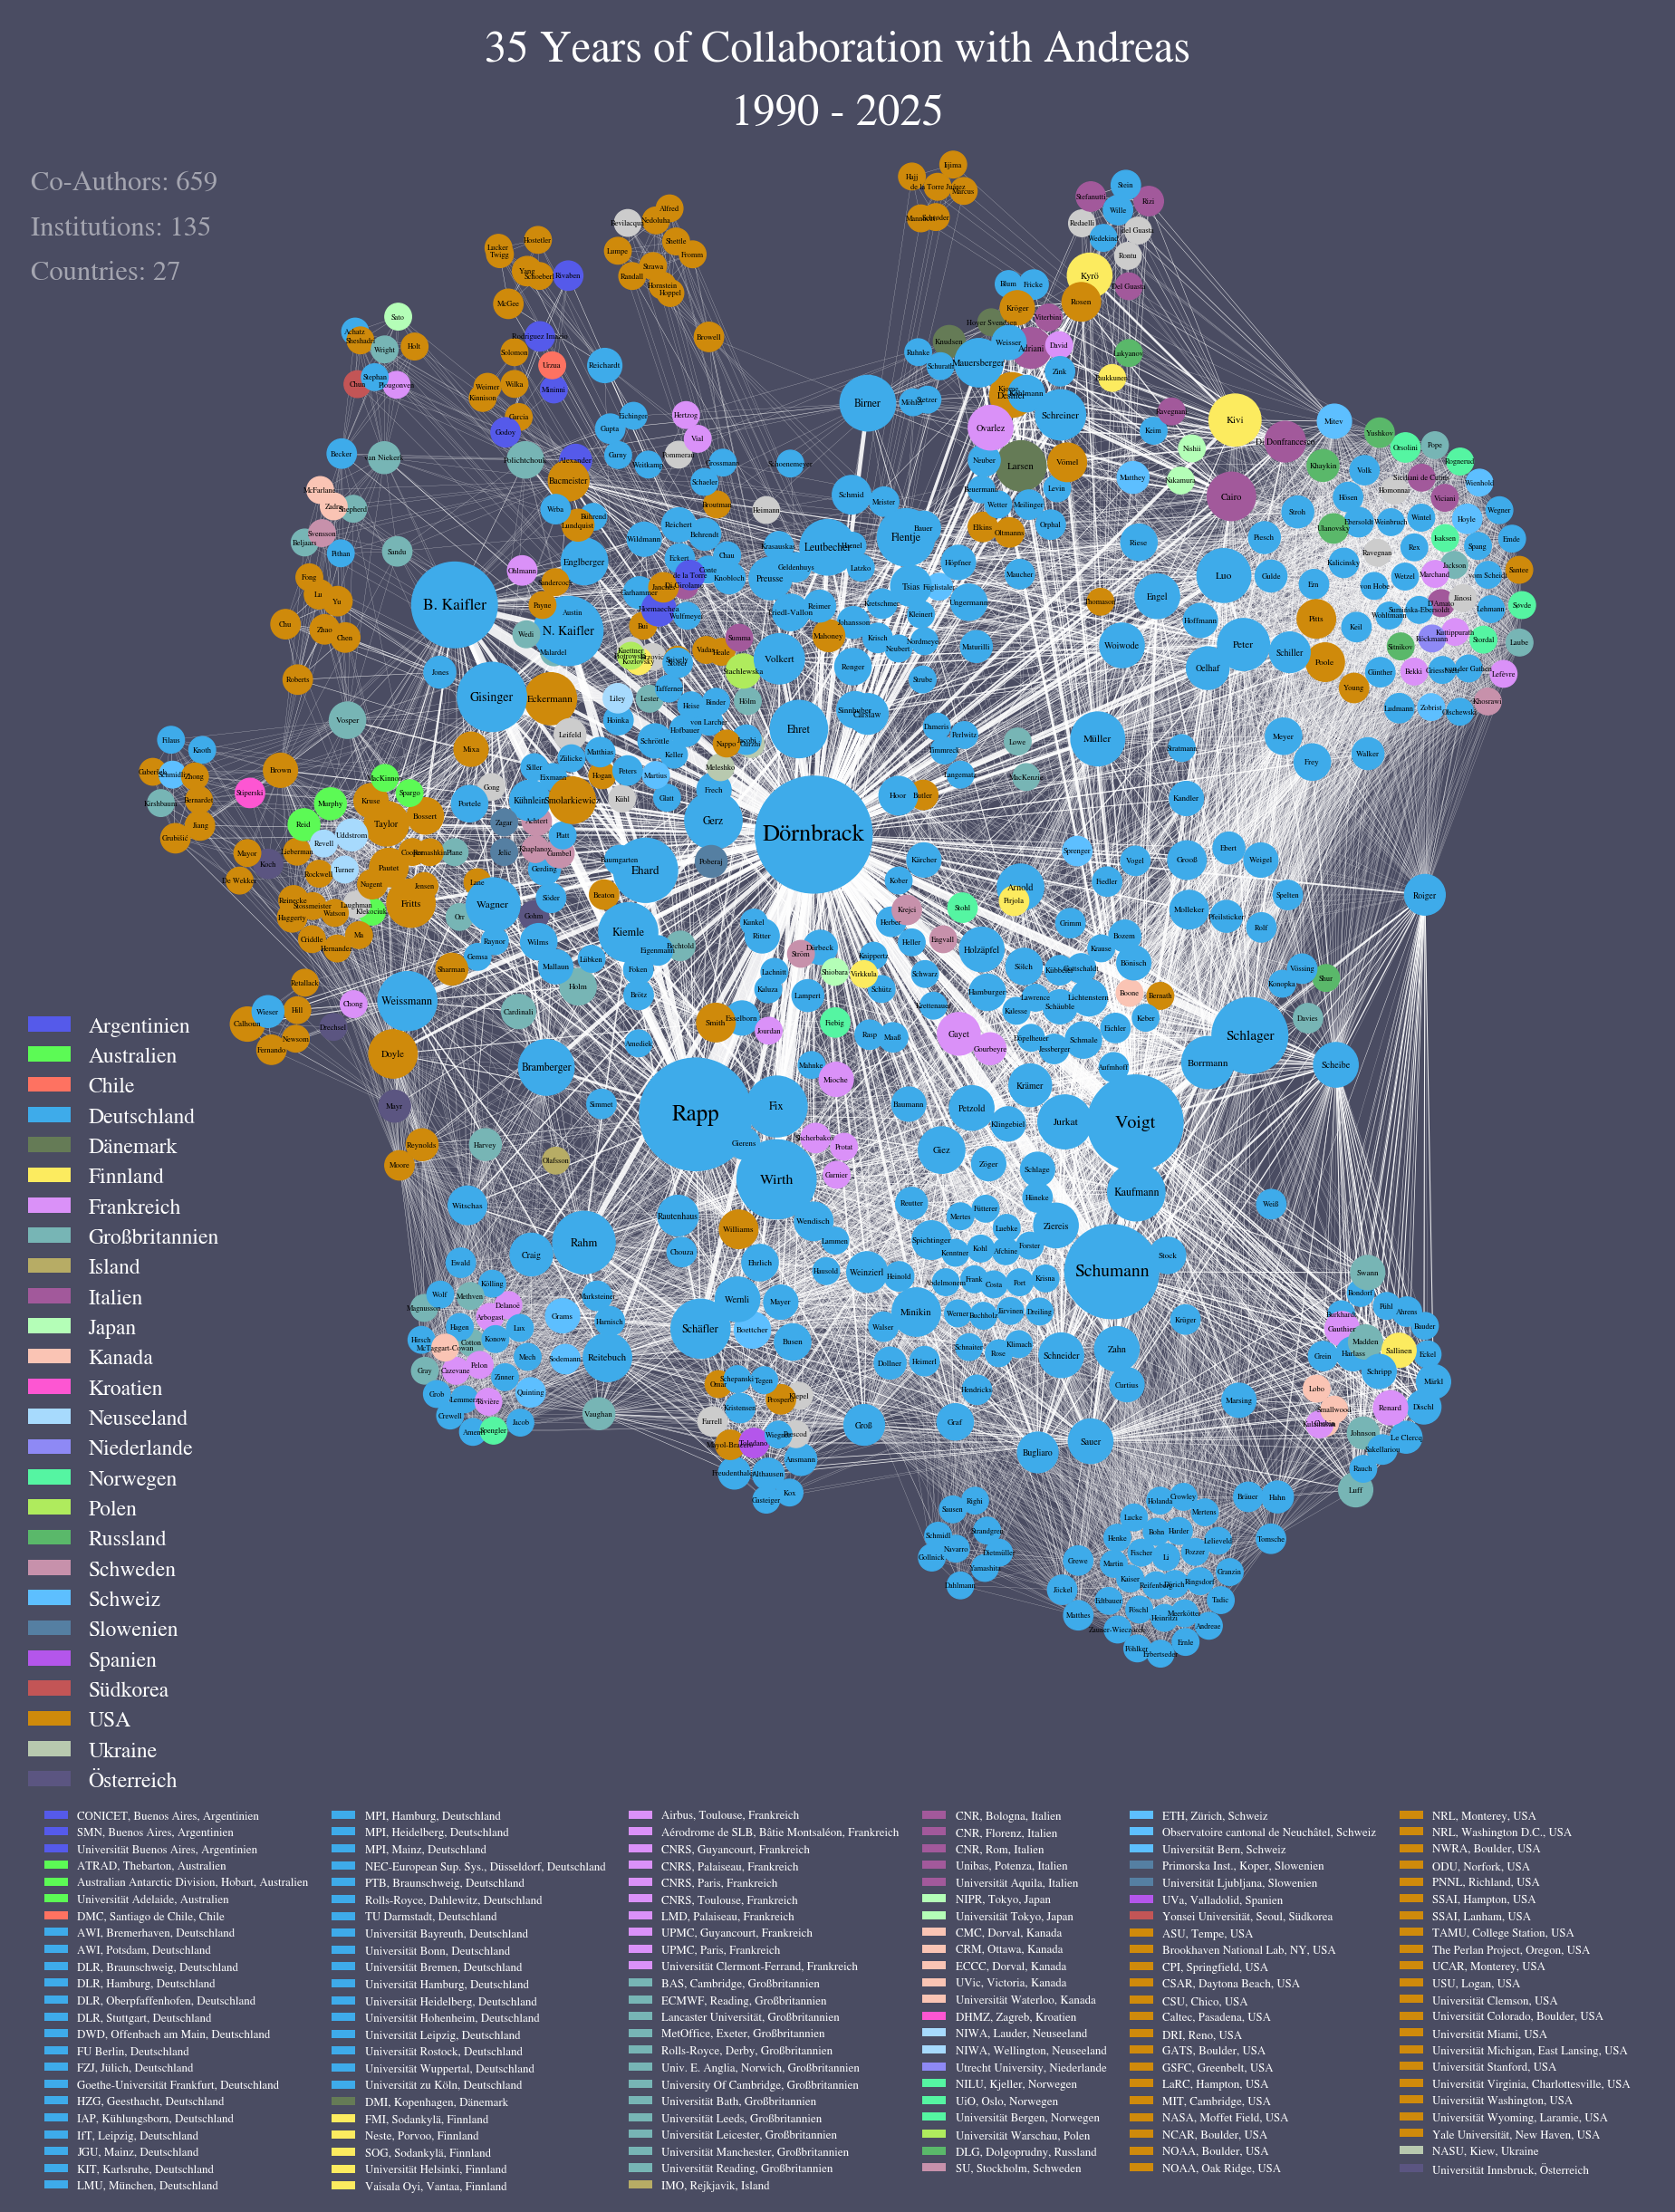

In [30]:
# %%capture

## Build graph (add nodes and edges)
G = nx.Graph()
G.add_nodes_from(authors)
nx.set_node_attributes(G, author_group_map, name='group')

for i, author_a in enumerate(authors):
    for j, author_b in enumerate(authors):
        weight = coauthor_matrix[i][j]
        if i < j and weight > 0:
            G.add_edge(author_a, author_b, weight=weight)


## Match countries -> colors
def get_country(institution_str):
    try:
        return institution_str.strip().split(',')[-1].strip()
    except:
        return "Unknown"

author_country_map = {}
for author in G.nodes():
    inst = G.nodes[author].get('group', None)
    if inst:
        country = get_country(inst)
        author_country_map[author] = country
    else:
        author_country_map[author] = "Unknown"

sorted_unique_countries = sorted(set(author_country_map.values()))
n_countries = len(sorted_unique_countries)

## Colormap
random.seed(6)
# np.random.seed(1)
# base_cmap = colormaps.get_cmap('tab20')
# cmap_colors = [base_cmap(i / N) for i in range(N)]
base_cmap = distinctipy.get_colors(n_countries, pastel_factor=0.5) # pastel_factor=1
cmap_colors = [base_cmap[i] for i in range(n_countries)]
cmap_colors[3] = '#3eabea'
cmap_colors[-4] = '#cf8a0b'

country_to_color = {
    country: mcolors.to_hex(cmap_colors[i]) if country != "Unknown" else "#cccccc"  for i, country in enumerate(sorted_unique_countries)
}

node_colors = []
for author in G.nodes():
    country = author_country_map.get(author, "Unknown")
    color = country_to_color.get(country, "#cccccc")  # fallback: gray
    node_colors.append(color)

## Match groups -> colors
unique_groups = list(set(author_group_map.values()))
group_to_color = {g: country_to_color.get(get_country(g), "#cccccc") for g in unique_groups}

sorted_groups = sorted(
    group_to_color.items(),
    key=lambda x: (get_country(x[0]), x[0])
)

## Network algorithm
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=False,
    # linLogMode=False,
    # adjustSizes=False,
    edgeWeightInfluence=10,
    jitterTolerance=0.1, # Smoother movements, longer convergence but less mess.
    barnesHutOptimize=False,
    barnesHutTheta=0.1,
    scalingRatio=20.0, # 15, Pushes nodes further apart overall.
    strongGravityMode=False,
    gravity=0, # attraction towards center (not needed since on person attracts all)
    verbose=True, # progress bar
)

## Iterate over seeds to find best network assembly
# seeds = np.arange(2050,4050,50)
# seeds = [200, 400, 550, 600, 1550, 1600]
seeds = [400]
for seed in seeds:
    random.seed(seed)
    pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=10000) # 20.000 did look good
    # pos = nx.spring_layout(G, pos=pos, k=3, iterations=5)

    edges = G.edges(data=True)
    weights = [edata['weight'] for _, _, edata in edges]
    print('Maximum weight: ', max(weights))

    # Scaling of edge widths (exponential)
    width_range = [0.15,16]
    exp_weights = [np.exp(w / max(weights)) for w in weights]
    min_exp, max_exp = min(exp_weights), max(exp_weights)
    edge_widths = [
        width_range[0] + (width_range[1] - width_range[0]) * (w - min_exp) / (max_exp - min_exp)
        for w in exp_weights
    ]

    # alpha_range = [1,0.2]
    # edge_alphas = [alpha_range[0] - ((alpha_range[1]-alpha_range[0]) * w / (max(weights))) for w in weights]
    # edge_alphas = [1 if edge_alpha > 1 else edge_alpha for edge_alpha in edge_alphas]

    # Scaling of node size and text size
    # ns_range = [400,4000] # linear scaling
    # fs_range = [6,14]     # linear scaling
    ns_range = [450,8000]   # exp. scaling
    fs_range = [6,18]       # exp. scaling
    ref_node = "Dörnbrack"
    node_sizes = []
    font_sizes = []
    for author in G.nodes():
        if author != ref_node:
            w = G.get_edge_data(author,ref_node)['weight']
        else:
            w = 1.05 * max(weights)
        # node_sizes.append(ns_range[0] + (ns_range[1]-ns_range[0]) * w / max(weights))
        # font_sizes.append(fs_range[0] + (fs_range[1]-fs_range[0]) * w / max(weights))
        w = np.exp(w / max(weights))
        node_sizes.append(ns_range[0] + (ns_range[1]-ns_range[0]) * (w - min_exp) / (max_exp - min_exp))
        font_sizes.append(fs_range[0] + (fs_range[1]-fs_range[0]) * (w - min_exp) / (max_exp - min_exp))

    def avoid_node_overlaps(pos, ns, min_dist=100, move_strength=100, ref_node="Dörnbrack"):
        """ns is same order as nodes (pos.keys())"""
        nodes = list(pos.keys())
        for i in range(len(nodes)):
            xi, yi = pos[nodes[i]]
            min_dist_temp = min_dist * (1 + 8 * (ns[i]-min(ns))/(max(ns)-min(ns)))
            move_strength_temp = move_strength * (1 + 8 * (ns[i]-min(ns))/(max(ns)-min(ns)))
            not_ref_node = True
            if nodes[i] == ref_node:
                not_ref_node = False
                min_dist_temp = 2 * min_dist
                move_strength_temp = 30 * move_strength
            for j in range(i+1, len(nodes)):
                xj, yj = pos[nodes[j]]
                dx = xi - xj
                dy = yi - yj
                dist = np.sqrt(dx*dx + dy*dy)
                if dist < min_dist_temp and dist > 0:
                    # Push them apart (closer = stronger push)
                    push = move_strength_temp / (dist**2)
                    push_x = push * dx
                    push_y = push * dy
                    if not_ref_node:
                        xi += push_x
                        yi += push_y
                    xj -= push_x
                    yj -= push_y
                    pos[nodes[i]] = (xi, yi)
                    pos[nodes[j]] = (xj, yj)
        return pos

    pos = avoid_node_overlaps(pos, node_sizes, min_dist=150, move_strength=600)

    ## Figure / Plotting 
    # fsize = 23.4 # DIN A1
    # ffactor = 1.414
    fsize = 23.6 # 60 x 80
    ffactor = 1.33333334
    spacing = 0.01
    fig, axes = plt.subplots(2,1, figsize=(fsize, ffactor*fsize), gridspec_kw={"wspace": spacing, "hspace": spacing, "height_ratios":[5,1.06]})
    # plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["font.serif"] = "cm"
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
    plt.rcParams['ps.fonttype'] = 42

    ax = axes[0]
    ax_cb = axes[1]

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, node_size=node_sizes)
    # nx.draw_networkx_edges( G, pos, ax=ax, edge_color='black', width=edge_widths, alpha=0.9)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='white', width=edge_widths, alpha=0.9)

    # nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    i = 0
    for node, (x, y) in pos.items():
        ax.text(
            x, y, node,
            fontsize=font_sizes[i],
            color='black',
            ha='center',
            va='center'
        )
        i+=1

    fontc = 'white'
    legend_elements = [Patch(facecolor=color, label=country) for country, color in country_to_color.items() if country != "Unknown"]
    ax.legend(handles=legend_elements, loc='lower left', ncol=1, fontsize=17, labelcolor=fontc, frameon=False)

    legend_elements = [Patch(facecolor=c, label=g) for g, c in sorted_groups]
    ax_cb.legend(handles=legend_elements, loc='lower center', ncol=6, fontsize=9.3, labelcolor=fontc, frameon=False)

    ax.axis('off')
    ax_cb.axis('off')
    ax.text(
        0.5, 0.988,
        "35 Years of Collaboration with Andreas",
        transform=ax.transAxes,
        fontsize=35,
        color=fontc,
        ha='center',  
        va='top', 
    )
    ax.text(
        0.5, 0.953,
        "1990 - 2025",
        transform=ax.transAxes,
        fontsize=35,
        color=fontc,
        ha='center',  
        va='top', 
    )

    # ax.text(
    #     0.8, 0.2,
    #     f"Co-Authors: {len(authors)}\nInstitutions: {len(sorted_groups)}\nCountries: {len(country_to_color)}",
    #     transform=ax.transAxes,
    #     fontsize=17,
    #     color=fontc,
    #     ha='center',  
    #     va='top',
    #     # alpha=0.5,
    #     # rotation=30
    # )

    ax.text(
        0.013, 0.91,
        f"Co-Authors: {len(authors)}",
        # "135 Institutions",
        transform=ax.transAxes,
        # fontsize=17,
        fontsize=22,
        color=fontc,
        ha='left',  
        va='top',
        alpha=0.5,
        # rotation=-30
    )

    ax.text(
        0.013, 0.885,
        f"Institutions: {len(sorted_groups)}",
        # "135 Institutions",
        transform=ax.transAxes,
        # fontsize=17,
        fontsize=22,
        color=fontc,
        ha='left',  
        va='top',
        alpha=0.5,
        # rotation=-30
    )

    ax.text(
        0.013, 0.86,
        f"Countries: {len(country_to_color)}",
        # "135 Institutions",
        transform=ax.transAxes,
        # fontsize=17,
        fontsize=22,
        color=fontc,
        ha='left',  
        va='top',
        alpha=0.5,
        # rotation=-30
    )

    ## Comments:
    ## - PDF file size much smaller, but arrows do not become as thin as with png
    ## - fs of 6 for A1 format seems to be a good compromise
    bgc = '#4a4c62' # 'steelblue'
    fig.set_facecolor(bgc)
    plt.savefig('./plots/Andreas_collaboration_v12.png', dpi=450, facecolor=bgc, edgecolor=bgc, bbox_inches="tight")
    plt.savefig(f"./plots/Andreas_collaboration_v12_seed_{seed}.png", dpi=100, facecolor=bgc, edgecolor=bgc, bbox_inches="tight")
    # plt.savefig('./plots/Andreas_collaboration_v11.pdf',format='pdf', dpi=450, facecolor=bgc, edgecolor=bgc, bbox_inches="tight")

In [9]:
print(f"Co-Autoren: {len(authors)}")
print(f"Institutions: {len(sorted_groups)}")
print(f"Countries: {len(country_to_color)}")

Co-Autoren: 659
Institutions: 135
Countries: 27


In [26]:
print(authors)

['Abdelmonem', 'Achatz', 'Achtert', 'Adriani', 'Afchine', 'Ahrens', 'Alexander', 'Alfred', 'Althausen', 'Amediek', 'Ament', 'Andreae', 'Ansmann', 'Arbogast', 'Arnold', 'Aufmhoff', 'Austin', 'B. Kaifler', 'Bacmeister', 'Bauder', 'Bauer', 'Baumann', 'Baumgarten', 'Beaton', 'Bechtold', 'Becker', 'Behrendt', 'Bekki', 'Beljaars', 'Bernardet', 'Bernath', 'Beuermann', 'Bevilacqua', 'Binder', 'Birner', 'Blum', 'Boettcher', 'Bohn', 'Bondorf', 'Boone', 'Borrmann', 'Bossert', 'Bozem', 'Bramberger', 'Broutman', 'Browell', 'Brown', 'Brzovic', 'Bräuer', 'Brötz', 'Buchholz', 'Bugliaro', 'Bui', 'Burkhardt', 'Busen', 'Butler', 'Bönisch', 'Bührend', 'Cairo', 'Calhoun', 'Cardinali', 'Carslaw', 'Cazevane', 'Chau', 'Chen', 'Chong', 'Chouza', 'Chu', 'Chun', 'Conte', 'Cooper', 'Corbin', 'Costa', 'Cotton', 'Craig', 'Crewell', 'Criddle', 'Crowley', 'Curtius', "D'Amato", 'Dahlmann', 'Dameris', 'David', 'Davies', 'De Wekker', 'Del Guasta', 'Delanoë', 'Deshler', 'Di Donfrancesco', 'Di Girolamo', 'Dietmüller', 'Di

In [20]:
## Plotly
import plotly.graph_objects as go

# Extract positions
xs = [pos[author][0] for author in authors]
ys = [pos[author][1] for author in authors]

# Create node scatter
node_trace = go.Scatter(
    x=xs,
    y=ys,
    mode='markers+text',
    text=authors,
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        color=node_colors,
        size=10,
        line=dict(width=1, color='black')
    )
)

# Create edge traces
edge_x = []
edge_y = []

for i, author_a in enumerate(authors):
    for j, author_b in enumerate(authors):
        weight = coauthor_matrix[i][j]
        if i < j and weight > 0:
            x0, y0 = pos[author_a]
            x1, y1 = pos[author_b]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='rgba(150,150,150,0.3)'),
    hoverinfo='none',
    mode='lines'
)

fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='Co-authorship Network (ForceAtlas2 Layout)',
        # titlefont_size=20,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=10, l=10, r=10, t=50),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        height=900,
    )
)

fig.show()